# NLP - Text Classification using TF-IDF Vectors

**Part of Kaggle competetion hosted @<a href=https://www.kaggle.com/competitions/nlp-getting-started/overview>Competetion Link</a>**

Text classification is one of the fundamental analytical tasks in NLP domain. Some of the applications include but not limited to
- Spam detection
- Customer intent categorization
- Document classification
- Product categorization
- Sentiment classification

Since text data is not machine understandable, we need to convert it into usable format. One such technique is to use occurrence of word as a feature. We can build a list of words that are useful & create separate feature for each word indicating corresponding text has it or not (or indicating number of occurrences).

If we directly use the top words (Term frequency), we might end up using a lot of unnecessary words as features. To mitigate it we can
- Build stop words list
- Use TF-IDF scores to determine the top words


**Term Frequency times Inverse document frequency (TF-IDF):** 
<br></br>
<p style="text-align: center;">
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mtext>tf-idf(t,d)</mtext>
  <mo>=</mo>
  <mtext>tf(t,d)</mtext>
  <mo>&#xD7;</mo>
  <mtext>idf(t)</mtext>
</math>
</p>

- tf(t,d) - Term frequency / Number of occurrences  of term "t" in document "d"
- idf(t) - 
<br></br>
<p style="text-align: center;">
  <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mtext>idf</mtext>
  <mo stretchy="false">(</mo>
  <mi>t</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>log</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mrow data-mjx-texclass="ORD">
    <mfrac>
      <mrow>
        <mn>1</mn>
        <mo>+</mo>
        <mi>n</mi>
      </mrow>
      <mrow>
        <mn>1</mn>
        <mo>+</mo>
        <mtext>df</mtext>
        <mo stretchy="false">(</mo>
        <mi>t</mi>
        <mo stretchy="false">)</mo>
      </mrow>
    </mfrac>
  </mrow>
  <mo>+</mo>
  <mn>1</mn>
</math>
</p>

Where n - Total number of documents , df(t) is number of documents containing term "t". IDF approaches 1 as df(t) approaches n.
<br></br>
***You can read more about it @*** <a href="https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting">Sklearn-TF-IDF</a>

Let's dive into build our text classifier!! 




## Data description


Dataset contains tweets from Twitter, containing tweets related to real disasters & other similar tweets.<br>
Challenge was to identify which ones are real disaster tweets.

## Imports

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
%matplotlib inline


### Loading data set

In [3]:
train_file = '<train_file_path>'
test_file = '<test_file_path>'

In [4]:
train_df = pd.read_csv(train_file)

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


- Distribution of the target variable

In [6]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

- Checking if length of the tweet has any indication

In [7]:
train_df['length'] = train_df['text'].apply(len)

<Axes: ylabel='Frequency'>

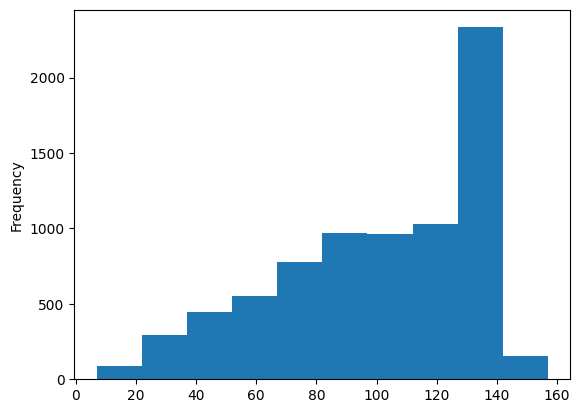

In [8]:
train_df['length'].plot(kind='hist')

<Axes: title={'center': 'Other tweets'}, ylabel='Frequency'>

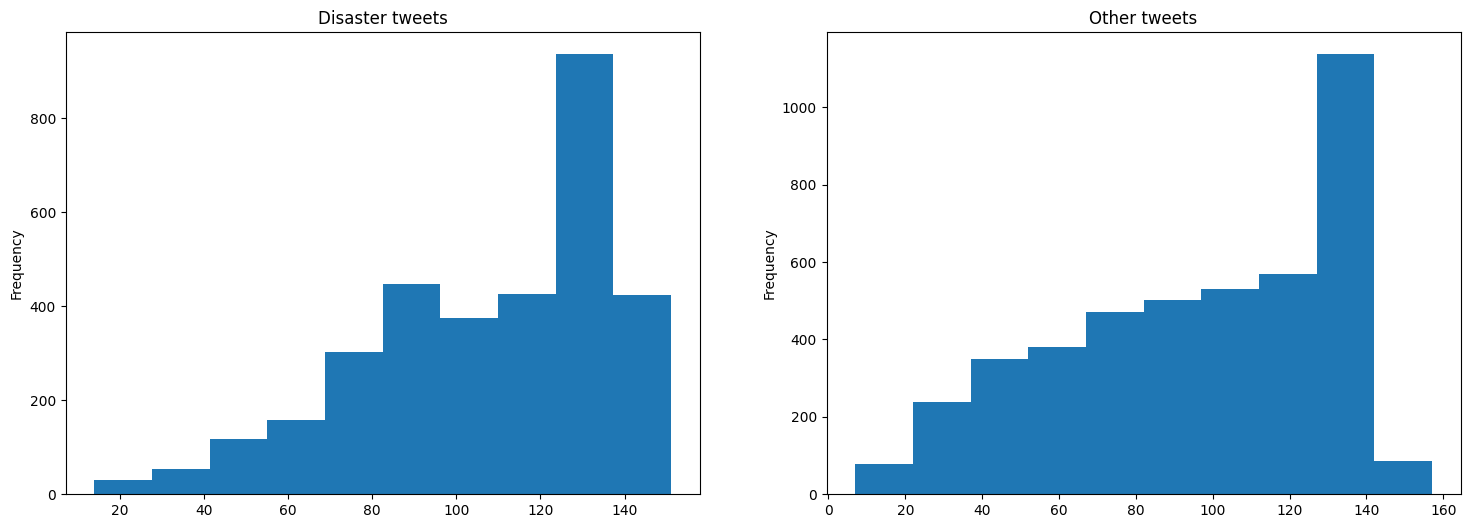

In [9]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
train_df[train_df['target']==1]['length'].plot(kind='hist',title='Disaster tweets')
plt.subplot(1,2,2)
train_df[train_df['target']==0]['length'].plot(kind='hist',title='Other tweets')

- Disaster tweets have more longer tweets than normal.
- Both kind of tweets are maxing at the right tail, indicating a limit on the tweets themselves imposed by external factors. (Here it is platform limit of 160 characters.)

### Understanding the distribution of keywords

**Hashtags analysis**

In [10]:
def get_all_hashtags(text):
    """
        Given a text retrieves hashtags present in it.
        Params:
            text: Input text
        returns: List of hashtags
    """
    # Assumption : Hashtags are contiguous text without spaces in b/w
    return [word for word in text.split() if word.startswith('#')]

In [11]:
train_df['hashtags'] = train_df['text'].apply(get_all_hashtags)

In [12]:
print(f"% of tweets with Hashtags present : {(train_df[train_df['hashtags'].apply(len) > 0 ].shape[0] / train_df.shape[0]) * 100}")

print(f"% of tweets with Hashtags present in disaster tweets: {(train_df[(train_df['hashtags'].apply(len) > 0) & (train_df['target']==1)].shape[0] / train_df[train_df['target']==1].shape[0]) * 100}")

print(f"% of tweets with Hashtags present in other tweets: {(train_df[(train_df['hashtags'].apply(len) > 0) & (train_df['target']==0)].shape[0] / train_df[train_df['target']==0].shape[0]) * 100}")

% of tweets with Hashtags present : 22.776829108104558
% of tweets with Hashtags present in disaster tweets: 26.199938856618772
% of tweets with Hashtags present in other tweets: 20.198065407646247


**Only slightly higher chance of finding a hashtag in disaster tweets compared to other tweets**

In [13]:
disaster_hashtags = list()
other_hashtags = list()

_ = [disaster_hashtags.extend(hashtags) for hashtags in (train_df[train_df['target']==1]['hashtags'].values)]
_ = [other_hashtags.extend(hashtags) for hashtags in (train_df[train_df['target']==0]['hashtags'].values)]

**Looking at the frequency of hashtags**

In [14]:
print(f"Top hashtags of disasters : {list(pd.Series(disaster_hashtags).value_counts()[:50].index)}")

print(f"\n Top hashtags of non disasters : {list(pd.Series(other_hashtags).value_counts()[:50].index)}")

Top hashtags of disasters : ['#News', '#???', '#news', '#Hiroshima', '#??', '#prebreak', '#hot', '#best', '#India', '#yyc', '#Sismo', '#Japan', '#earthquake', '#ISIS', '#terrorism', '#abstorm', '#WX', '#Earthquake', '#world', '#okwx', '#CNN', '#Rohingya', '#Fukushima', '#Africa', '#BBC', '#Antioch', '#Bestnaijamade:', '#wildfires', '#disaster', '#science', '#Libya', '#drought', '#Sittwe', '#Myanmar', '#socialnews', '#Islam', '#wildfire', '#hailstorm', '#WorldNews', '#\x89Û_', '#Zionist', '#GBBO', '#Terrorist', '#California', '#Nuclear', '#RockyFire', '#EarthQuake', '#Phoenix', '#photography', '#Lies']

 Top hashtags of non disasters : ['#hot', '#prebreak', '#best', '#news', '#GBBO', '#nowplaying', '#NowPlaying', '#jobs', '#EDM', '#Beyhive', '#Directioners', '#DnB', '#islam', '#RT', '#animalrescue', '#Dance', '#Ices\x89Û_', '#TrapMusic', '#Dubstep', '#Nursing', '#MTVHottest', '#Emmerdale', '#Seattle', '#job', '#News', '#Womens', '#Handbag', '#', '#Jobs', '#Fashion', '#Job', '#kindle', '

**Similar Hashtags are being used for both kind of tweets. & % of Tweets with hashtags also low at 20% so solely can't be used for classification.**

In [15]:
train_df.keyword.value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [16]:
print(f"% of the data points with keyword available : {(train_df.keyword.notnull().sum() / train_df.shape[0])*100}")

% of the data points with keyword available : 99.19873899908052


In [17]:
top_50_keywords_disaster = list(train_df[train_df['target']==1].keyword.value_counts()[:50].index)
top_50_keywords_other = list(train_df[train_df['target']==0].keyword.value_counts()[:50].index)
print("Top keywords in disaster tweets : \n", top_50_keywords_disaster)

print("\nTop keywords in other tweets : \n", top_50_keywords_other)

print("Common keywords :",[keyword for keyword in top_50_keywords_disaster if keyword in top_50_keywords_other])

Top keywords in disaster tweets : 
 ['derailment', 'wreckage', 'outbreak', 'debris', 'oil%20spill', 'typhoon', 'evacuated', 'suicide%20bombing', 'rescuers', 'suicide%20bomb', 'nuclear%20disaster', 'razed', 'suicide%20bomber', 'earthquake', 'airplane%20accident', 'collision', 'wildfire', 'bridge%20collapse', 'evacuation', 'buildings%20on%20fire', 'mass%20murder', 'casualties', 'sandstorm', 'drought', 'forest%20fires', 'devastation', 'hostages', 'bombing', 'wild%20fires', 'sinkhole', 'famine', 'thunderstorm', 'fatal', 'displaced', 'derailed', 'fatalities', 'floods', 'deaths', 'wounded', 'violent%20storm', 'massacre', 'attack', 'flooding', 'evacuate', 'heat%20wave', 'dust%20storm', 'injured', 'hailstorm', 'terrorism', 'accident']

Top keywords in other tweets : 
 ['body%20bags', 'harm', 'armageddon', 'wrecked', 'ruin', 'deluge', 'explode', 'twister', 'fear', 'siren', 'aftershock', 'panic', 'screaming', 'blizzard', 'blazing', 'blaze', 'crush', 'sinking', 'traumatised', 'curfew', 'upheaval'

**Keywords of both disaster and other indicating similar kind of words.**

### Building a simple classifier using Tf-Idf vectors

- Terms can be single word or n-grams. In this approach we will use n-grams upto 3 grams.

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),max_features=10000)

- We will be using cross validation technique to identify the best parameters of our model, so not splitting the data into train & validation sets explicitly

In [20]:
X = vectorizer.fit_transform(train_df['text'])

In [21]:
y = train_df['target']

**Testing Gradient boosting classifier.**

In [22]:
gbc = GradientBoostingClassifier(random_state=42)

- We will be tuning 2 improtant hyper parameters
    - Number of estimators  - Indicates number of successive iterations of decision trees.
    - Max depth - Indicates complexity of individual decision tree.
- We will be using F1 score as the metric for tuning our model

In [23]:
params_grid = {
    "n_estimators":[100,200,300,400,500],
    "max_depth":[3,5,10]
}

In [24]:
f1 = make_scorer(f1_score , average='macro')

In [25]:
gcv = GridSearchCV(estimator = gbc, 
             param_grid = params_grid, 
             cv = 3, 
             n_jobs = -1, 
             verbose = 4,
             scoring=f1)

In [26]:
gcv.fit(X,y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring=make_scorer(f1_score, average=macro), verbose=4)

In [27]:
print("Best F1 score : ", gcv.best_score_)

Best F1 score :  0.6847480964443878


**Trying out Random Forest classifier**

In [28]:
rf = RandomForestClassifier(random_state=42)

In [29]:
gcv_rf = GridSearchCV(estimator = rf, 
             param_grid = params_grid, 
             cv = 3, 
             n_jobs = -1, 
             verbose = 4,
             scoring=f1)

In [30]:
gcv_rf.fit(X,y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring=make_scorer(f1_score, average=macro), verbose=4)

In [31]:
print("Best F1 score : ", gcv_rf.best_score_)

Best F1 score :  0.4739887854271538


**It looks like Gradient boosting is giving better results**

In [32]:
from xgboost import XGBClassifier

In [33]:
xgb = XGBClassifier(random_state=42)

In [34]:
gcv_xgb = GridSearchCV(estimator = xgb, 
             param_grid = params_grid, 
             cv = 3, 
             n_jobs = -1, 
             verbose = 4,
             scoring=f1)

In [35]:
gcv_xgb.fit(X,y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring=make_scorer(f1_score, average=macro), verbose=4)

In [36]:
print("Best F1 score : ", gcv_xgb.best_score_)

Best F1 score :  0.6915583732223548


**XGBoost seems to be giving best F1 score. So Lets go ahead with submision.**

In [37]:
test_df = pd.read_csv(test_file)

In [38]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [39]:
predictions = gcv_xgb.predict(vectorizer.transform(test_df['text']))

In [40]:
test_df['target'] = predictions

In [41]:
test_df[['id','target']].to_csv('/kaggle/working/submission.csv')

***Follow my next notebook @ <a href='https://github.com/giridharmunagala/nlp_learnings/blob/main/text_classification/nlp-text-classification-word2vec.ipynb'>Word2Vec</a> for classification based on embeddings.***


### Data set Citation 
Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started
